# Set-up

In [390]:
# Importing libraries
import os
import glob
import json

import numpy as np
import pandas as pd

import matplotlib.pyplot as plt
import seaborn as sns

In [391]:
# Paths
path_fragments_counts = "/cellar/users/aklie/data/datasets/igvf_sc-islet_10X-Multiome/results/4_integration/atac/pseudobulk/rna_celltype/12-1/fragments/frag_counts.tsv"
path_narrowPeaks_dir = "/cellar/users/aklie/data/datasets/igvf_sc-islet_10X-Multiome/results/5_peak_analysis/peak_calls/rna_celltype/12-1/snapatac2"
path_bc_metadata = "/cellar/users/aklie/data/datasets/igvf_sc-islet_10X-Multiome/results/5_peak_analysis/peak_calls/rna_celltype/12-1/snapatac2/integrate/round_1/cell_metadata.tsv"
path_out = "/cellar/users/aklie/data/datasets/igvf_sc-islet_10X-Multiome/results/8_chrombpnet/rna_celltype_250k"

# Data overview

In [395]:
# Load fragment counts to start
fragment_counts = pd.read_csv(path_fragments_counts, sep="\t", index_col=0).to_dict()["fragments"]

# Get number of narrowPeaks per celltype
narrowPeaks = {}
for f in glob.glob(f"{path_narrowPeaks_dir}/*.narrowPeak"):
    celltype = os.path.basename(f).split(".narrowPeak")[0]
    narrowPeaks[celltype] = len(pd.read_csv(f, sep="\t", header=None))
narrowPeaks = {k: v for k, v in narrowPeaks.items() if "top" not in k}

# Get number of cells per celltype
bc_metadata = pd.read_csv(path_bc_metadata, sep="\t", index_col=0)
cells_per_celltype = bc_metadata.groupby("rna_celltype").size()

# Make a df that looks like this: Cell Type	Number of Barcodes	Number of Fragments	Number of Peak Calls
df = pd.DataFrame({
    "Number of Barcodes": cells_per_celltype,
    "Number of Fragments": pd.Series(fragment_counts),
    "Number of Peak Calls": pd.Series(narrowPeaks)
})
df.index.name = "Cell Type"
df = df.sort_index(key=lambda x: x.str.lower())

# Save
df.to_csv(f"{path_out}/summary/data_overview.csv")

# Check
df

/cellar/users/aklie/opt/miniconda3/envs/get_data/lib/python3.7/site-packages/IPython/core/interactiveshell.py:3457: DtypeWarning: Columns (14) have mixed types.Specify dtype option on import or set low_memory=False.
  exec(code_obj, self.user_global_ns, self.user_ns)


,Number of Barcodes,Number of Fragments,Number of Peak Calls
Cell Type,,,
SC.alpha,71011,1002541303,374513
SC.beta,53686,874485670,419437
SC.delta,1356,20421056,109892
SC.EC,43549,695095274,421599


# Bias model overview

In [396]:
# Count up negatives used for each celltype and fold
negatives = {}
for f in glob.glob(f"{path_out}/*/fold_*/negatives/*.bed"):
    celltype = os.path.basename(f).split("_negatives.bed")[0]
    fold = f.split("/")[-3]
    if celltype not in negatives:
        negatives[celltype] = {}
    negatives[celltype][fold] = len(pd.read_csv(f, sep="\t", header=None))

# Turn into long form with celltype, fold, and count
negatives_df = pd.DataFrame(negatives).T.reset_index().melt(id_vars="index", var_name="fold", value_name="Number of Negatives")
negatives_df.columns = ["Cell Type", "Fold", "Number of Negatives"]
negatives_df = negatives_df.sort_values("Cell Type", key=lambda x: x.str.lower())

# Find all data parameters
bias_data_params = pd.DataFrame()
for f in glob.glob(f"{path_out}/*/*/bias_model/*/logs/*_bias_data_params.tsv"):
    celltype = f.split("/")[-6]
    fold = f.split("/")[-5]
    beta = f.split("/")[-3]
    curr_df = pd.read_csv(f, sep="\t", index_col=0, header=None).T
    curr_df["celltype"] = celltype
    curr_df["beta"] = beta
    curr_df["fold"] = fold
    bias_data_params = bias_data_params.append(curr_df)

# Find all jsons with performance metrics
bias_metrics = pd.DataFrame()
for f in glob.glob(f"{path_out}/*/*/bias_model/*/evaluation/*_bias_metrics.json"):
    celltype = f.split("/")[-6]
    fold = f.split("/")[-5]
    beta = f.split("/")[-3]
    with open(f, "r") as f:
        curr_dict = json.load(f)
    curr_dict = {f"{k1}_{k2}_{k3}": v3 for k1, v1 in curr_dict.items() for k2, v2 in v1.items() for k3, v3 in v2.items()}
    curr_df = pd.DataFrame(curr_dict, index=[0])
    curr_df["celltype"] = celltype
    curr_df["beta"] = beta
    curr_df["fold"] = fold
    bias_metrics = bias_metrics.append(curr_df)

# Merge dfs
bias = bias_data_params.merge(bias_metrics, on=["celltype", "beta", "fold"])
bias = bias.merge(negatives_df, left_on=["celltype", "fold"], right_on=["Cell Type", "Fold"])

# Clean up dataframe
bias_clean = bias[["celltype", "beta", "fold", "Number of Negatives", "counts_metrics_nonpeaks_pearsonr", "counts_metrics_peaks_pearsonr", "profile_metrics_nonpeaks_median_jsd", "profile_metrics_peaks_median_jsd"]]
bias_clean.columns = ["Cell Type", "Beta", "Fold", "Number of Negatives", "Bias Model Pearson r in Non-Peaks", "Bias Model Pearson r in Peaks", "Bias Model JSD in Non-Peaks", "Bias Model JSD in Peaks"]
bias_clean["lower_celltype"] = bias_clean["Cell Type"].str.lower()
bias_clean = bias_clean.sort_values(["lower_celltype", "Beta", "Fold"])
bias_clean = bias_clean[bias_clean["Beta"] == "0.8"]
bias_clean["Number of Negatives"] = bias_clean["Number of Negatives"].astype(int)
bias_clean["Bias Model Pearson r in Non-Peaks"] = bias_clean["Bias Model Pearson r in Non-Peaks"].round(2)
bias_clean["Bias Model Pearson r in Peaks"] = bias_clean["Bias Model Pearson r in Peaks"].round(2)
bias_clean["Bias Model JSD in Non-Peaks"] = bias_clean["Bias Model JSD in Non-Peaks"].round(2)
bias_clean["Bias Model JSD in Peaks"] = bias_clean["Bias Model JSD in Peaks"].round(2)
bias_clean = bias_clean.drop(columns="lower_celltype")

# Save
bias_clean.to_csv(f"{path_out}/summary/bias_metrics.csv", index=False)

# Check it
bias_clean.head()

/cellar/users/aklie/opt/miniconda3/envs/get_data/lib/python3.7/site-packages/ipykernel_launcher.py:49: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy


,Cell Type,Beta,Fold,Number of Negatives,Bias Model Pearson r in Non-Peaks,Bias Model Pearson r in Peaks,Bias Model JSD in Non-Peaks,Bias Model JSD in Peaks
0,SC.alpha,0.8,fold_0,446384,0.55,-0.25,0.47,0.34
8,SC.beta,0.8,fold_0,447067,0.50,-0.35,0.47,0.35
11,SC.beta,0.8,fold_1,449083,0.35,-0.44,0.48,0.34
9,SC.beta,0.8,fold_2,455269,0.40,-0.41,0.48,0.35
5,SC.beta,0.8,fold_3,446446,0.47,-0.36,0.47,0.34


# ChromBPNet model overview

In [398]:
# Same for full model
model_params = pd.DataFrame()
for f in glob.glob(f"{path_out}/*/*/chrombpnet/*/logs/*_model_params.tsv"):
    celltype = f.split("/")[-6]
    fold = f.split("/")[-5]
    beta = f.split("/")[-3]
    curr_df = pd.read_csv(f, sep="\t", index_col=0, header=None).T
    curr_df["celltype"] = celltype
    curr_df["beta"] = beta
    curr_df["fold"] = fold
    model_params = model_params.append(curr_df)

# Metrics
model_metrics = pd.DataFrame()
for f in glob.glob(f"{path_out}/*/*/chrombpnet/*/evaluation/chrombpnet_metrics.json"):
    celltype = f.split("/")[-6]
    fold = f.split("/")[-5]
    beta = f.split("/")[-3]
    with open(f, "r") as f:
        curr_dict = json.load(f)
    curr_dict = {f"{k1}_{k2}_{k3}": v3 for k1, v1 in curr_dict.items() for k2, v2 in v1.items() for k3, v3 in v2.items()}
    curr_df = pd.DataFrame(curr_dict, index=[0])
    curr_df["celltype"] = celltype
    curr_df["beta"] = beta
    curr_df["fold"] = fold
    model_metrics = model_metrics.append(curr_df)

# merge model_params and model_metrics
model = model_params.merge(model_metrics, on=["celltype", "beta", "fold"])

# Clean up dataframe
model_clean = model[["celltype", "beta", "fold", "counts_metrics_peaks_pearsonr", "profile_metrics_peaks_median_jsd"]]
model_clean.columns = ["Cell Type", "Beta", "Fold", "ChromBPNet Pearson r in Peaks", "ChromBPNet Median JSD in Peaks"]
model_clean["lower_celltype"] = model_clean["Cell Type"].str.lower()
model_clean = model_clean.sort_values(["lower_celltype", "Beta", "Fold"])
model_clean = model_clean.drop(columns="lower_celltype")
model_clean["ChromBPNet Pearson r in Peaks"] = model_clean["ChromBPNet Pearson r in Peaks"].round(2)
model_clean["ChromBPNet Median JSD in Peaks"] = model_clean["ChromBPNet Median JSD in Peaks"].round(2)

# Add columns for Predictions generated and Contributions generated (leave blank for now)
model_clean["Predictions Generated"] = ""
model_clean["Contributions Generated"] = ""

# Save
model_clean.to_csv(f"{path_out}/summary/model_metrics.csv", index=False)

# Check it
model_clean.head()

/cellar/users/aklie/opt/miniconda3/envs/get_data/lib/python3.7/site-packages/ipykernel_launcher.py:34: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy


,Cell Type,Beta,Fold,ChromBPNet Pearson r in Peaks,ChromBPNet Median JSD in Peaks,Predictions Generated,Contributions Generated
0,SC.alpha,0.8,fold_0,0.81,0.29,,
3,SC.alpha,0.8,fold_1,0.82,0.29,,
4,SC.alpha,0.8,fold_2,0.82,0.29,,
1,SC.alpha,0.8,fold_3,0.81,0.29,,
2,SC.alpha,0.8,fold_4,0.82,0.29,,


# Plots

In [387]:
celltype_colors = {
    "SC.beta": "#2a9df4",
    "SC.alpha": "#967bb6",
    "SC.EC": "#ff7f50",
    "SC.delta": "#dc143c"
}
celltype_order = ["SC.alpha", "SC.beta", "SC.EC"]

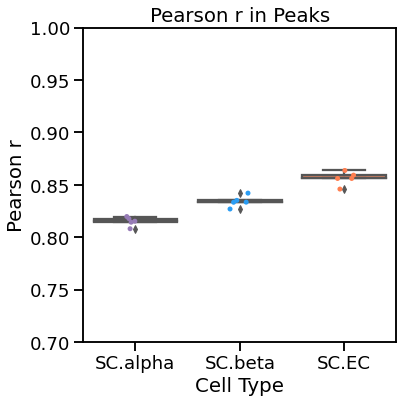

In [ ]:
# ChromBPNet Pearson r in Peak boxplot
with sns.plotting_context("talk", font_scale=1.1):
    fig, ax = plt.subplots(figsize=(6, 6))
    sns.boxplot(x="Cell Type", y="ChromBPNet Pearson r in Peaks", data=model_clean, palette=celltype_colors, order=celltype_order, ax=ax)
    sns.stripplot(x="Cell Type", y="ChromBPNet Pearson r in Peaks", data=model_clean, palette=celltype_colors, order=celltype_order, ax=ax)
    ax.set_title("Pearson r in Peaks")
    ax.set_ylabel("Pearson r")
    ax.set_xlabel("Cell Type")
    ax.set_ylim(0.7, 1)
    plt.tight_layout()
    plt.savefig(f"{path_out}/summary/ChromBPNet_Pearson_r_in_Peaks.png")
    plt.show()


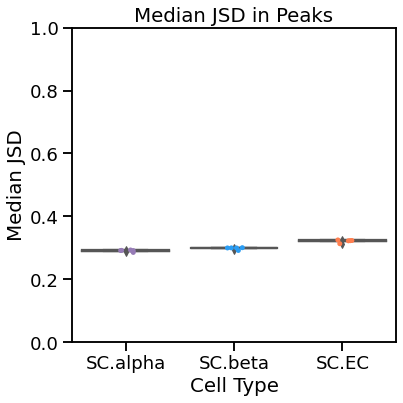

In [389]:
# ChromBPNet Median JSD in Peak boxplot
with sns.plotting_context("talk", font_scale=1.1):
    fig, ax = plt.subplots(figsize=(6, 6))
    sns.boxplot(x="Cell Type", y="ChromBPNet Median JSD in Peaks", data=model_clean, palette=celltype_colors, order=celltype_order, ax=ax)
    sns.stripplot(x="Cell Type", y="ChromBPNet Median JSD in Peaks", data=model_clean, palette=celltype_colors, order=celltype_order, ax=ax)
    ax.set_title("Median JSD in Peaks")
    ax.set_ylabel("Median JSD")
    ax.set_xlabel("Cell Type")
    ax.set_ylim(0, 1)
    plt.tight_layout()
    plt.savefig(f"{path_out}/summary/ChromBPNet_Median_JSD_in_Peaks.png")
    plt.show()

# DONE!

---